<a href="https://colab.research.google.com/github/joiortega1/Deep_Learning/blob/main/Tarea1/Tarea1_Ejercicio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1: Perceptrón y Redes Densas
- Ortega Ibarra Jaime Jesus

4. Entrena una red completamente conectada para clasificación multiclase en el conjunto CIFAR10

Importamos librerías a utilizar

In [44]:
import random
from itertools import islice as take
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchinfo import summary
from skimage import io
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.datasets import CIFAR10
from tqdm import trange

In [17]:
train_cifar = CIFAR10(root="../datasets", train=True, download=True, transform=T.ToTensor())
test_cifar = CIFAR10(root="../datasets", train=False, download=True, transform=T.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [18]:
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:4])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# reproducibilidad
set_seed()

Visualizamos nuestras imágenes

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


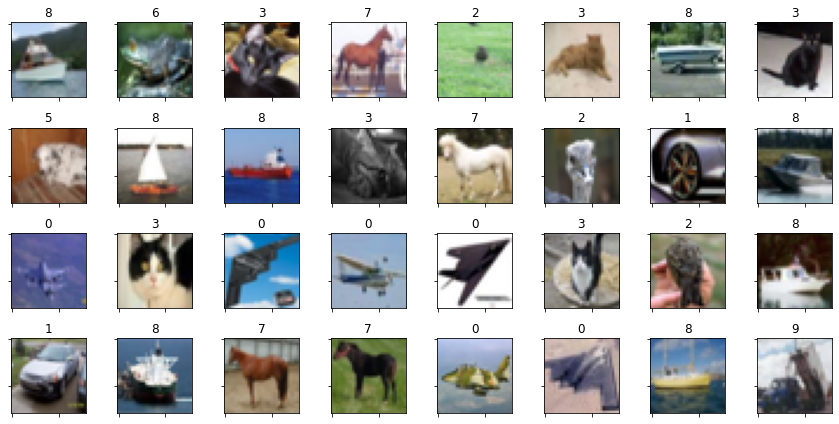

In [21]:
# creamos un DataLoader
train_cifar_dl = DataLoader(train_cifar, batch_size=BATCH_SIZE,shuffle=True)
test_cifar_dl = DataLoader(test_cifar,batch_size=BATCH_SIZE,shuffle=True)

x, y = next(iter(train_cifar_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

Creamos nuestro modelo

In [69]:
class CIFAR_Model(nn.Module):
    
     # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super().__init__()
        
        # tamaño de las capas
        self.I = 3 * 32 * 32
        FC1, FC2 = 128, 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 1x28x28] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            
            # fc2
            # [M, 128] => [M, 10]
            nn.Linear(FC1, FC2)
        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 1, 28, 28] => [M, 1x28x28]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 1x28x28]
        x = self.cls(x)
        
        return x

Funciones de entrenamiento

In [63]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
  

def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [70]:
model = CIFAR_Model()
print(model)

CIFAR_Model(
  (cls): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [72]:
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [73]:
summary(model, (3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 10]                   --
|    └─Linear: 2-1                       [1, 128]                  393,344
|    └─Sigmoid: 2-2                      [1, 128]                  --
|    └─Linear: 2-3                       [1, 10]                   1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.58
Estimated Total Size (MB): 1.59

In [74]:
model = CIFAR_Model()
loss_hist, acc_hist = train(model, train_cifar_dl, test_cifar_dl)

  5%|▌         | 1/20 [00:18<05:45, 18.16s/it]

E00 loss=[226.90,226.85] acc=[22.35,22.33]


 10%|█         | 2/20 [00:36<05:27, 18.22s/it]

E01 loss=[223.90,223.84] acc=[24.97,25.55]


 15%|█▌        | 3/20 [00:55<05:12, 18.37s/it]

E02 loss=[220.74,220.70] acc=[26.94,27.43]


 20%|██        | 4/20 [01:13<04:55, 18.48s/it]

E03 loss=[217.51,217.47] acc=[28.60,29.06]


 25%|██▌       | 5/20 [01:32<04:37, 18.53s/it]

E04 loss=[214.31,214.28] acc=[29.39,29.71]


 30%|███       | 6/20 [01:52<04:23, 18.81s/it]

E05 loss=[211.34,211.31] acc=[29.32,29.56]


 35%|███▌      | 7/20 [02:11<04:07, 19.07s/it]

E06 loss=[208.76,208.73] acc=[30.07,30.37]


 40%|████      | 8/20 [02:31<03:50, 19.22s/it]

E07 loss=[206.41,206.36] acc=[30.05,30.54]


 45%|████▌     | 9/20 [02:50<03:30, 19.17s/it]

E08 loss=[204.38,204.32] acc=[30.90,30.68]


 50%|█████     | 10/20 [03:09<03:11, 19.19s/it]

E09 loss=[202.57,202.53] acc=[31.29,31.08]


 55%|█████▌    | 11/20 [03:29<02:54, 19.39s/it]

E10 loss=[200.93,200.85] acc=[31.21,31.05]


 60%|██████    | 12/20 [03:49<02:35, 19.45s/it]

E11 loss=[199.50,199.45] acc=[31.23,30.97]


 65%|██████▌   | 13/20 [04:08<02:16, 19.44s/it]

E12 loss=[198.15,198.07] acc=[31.57,31.57]


 70%|███████   | 14/20 [04:27<01:55, 19.26s/it]

E13 loss=[196.94,196.86] acc=[32.01,31.74]


 75%|███████▌  | 15/20 [04:46<01:35, 19.16s/it]

E14 loss=[195.88,195.83] acc=[32.19,31.88]


 80%|████████  | 16/20 [05:05<01:16, 19.10s/it]

E15 loss=[194.85,194.79] acc=[32.50,32.02]


 85%|████████▌ | 17/20 [05:23<00:57, 19.01s/it]

E16 loss=[193.94,193.94] acc=[32.81,32.59]


 90%|█████████ | 18/20 [05:43<00:38, 19.06s/it]

E17 loss=[193.08,193.10] acc=[32.88,32.66]


 95%|█████████▌| 19/20 [06:01<00:18, 18.94s/it]

E18 loss=[192.31,192.26] acc=[33.37,33.32]


100%|██████████| 20/20 [06:20<00:00, 19.02s/it]

E19 loss=[191.61,191.57] acc=[33.23,32.92]


Visualizamos pérdida y exactitud

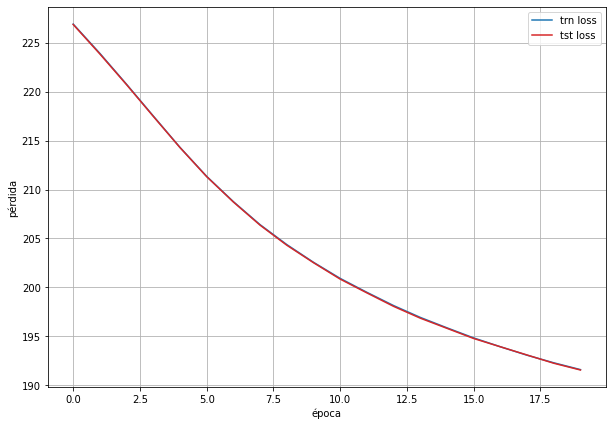

In [80]:
trn_loss, tst_loss = zip(*loss_hist)
plt.figure(figsize=(10,7))
plt.plot(trn_loss, 'tab:blue', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.grid()
plt.show()

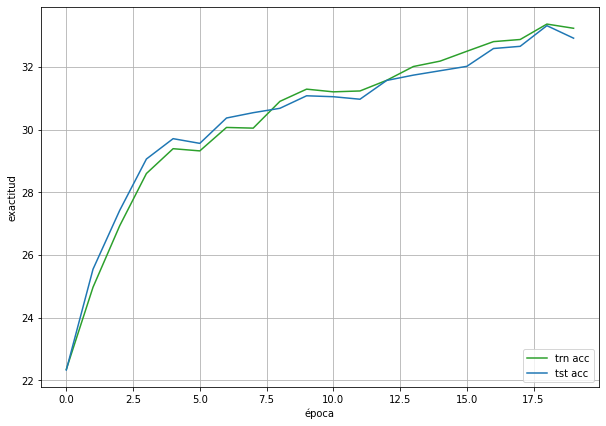

In [81]:
trn_acc, tst_acc = zip(*acc_hist)
plt.figure(figsize=(10,7))
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.grid()
plt.show()